load libraries

In [ ]:
system("mkdir site-library")
.libPaths("site-library")
R_environment_file <- "https://drive.usercontent.google.com/download?id=14aPVP7hBCEFUdkaHXWqz_wI8h5VuLsqs&export=download&authuser=0&confirm=t&uuid=609e8f24-8cf3-410d-ba9c-28639cb23f34&at=AN8xHooLEJIXoX2bOsSwRDXSfvD6:1754635911614"
download.file(R_environment_file, destfile="./library.tar.gz")
untar("library.tar.gz", "site-library")

library(forecast)
library(tseries)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [ ]:
# import data from Google shared drive
# https://drive.google.com/file/d/1GxiUd8FyVAnqc80WCl3zDOGaf2gbeTGz/view?usp=share_link
file_id <- "1GxiUd8FyVAnqc80WCl3zDOGaf2gbeTGz"
file_path <- paste0("https://drive.google.com/uc?export=download&id=", file_id)
data <- read.csv(file_path)

calculate inflation rate

In [ ]:
data$inflation_rate <- (data$CPI / lag(data$CPI, 12) - 1) * 100

create time series

In [ ]:
#fix the inflation rate calculation
data$inflation_rate <- c(rep(NA, 12),
                        (data$CPI[13:nrow(data)] / data$CPI[1:(nrow(data)-12)] - 1) * 100)

#check it worked
head(data[c("Date", "CPI", "inflation_rate")], 20)
summary(data$inflation_rate)


cpi_ts <- ts(data$CPI, start = c(1990, 1), frequency = 12)
inflation_ts <- ts(data$inflation_rate[!is.na(data$inflation_rate)],
                   start = c(1991, 1), frequency = 12)

,Date,CPI,inflation_rate
,<chr>,<dbl>,<dbl>
1,1990-01-01,127.4,NA
2,1990-02-01,128.0,NA
3,1990-03-01,128.7,NA
4,1990-04-01,128.9,NA
5,1990-05-01,129.2,NA
6,1990-06-01,129.9,NA
7,1990-07-01,130.4,NA
8,1990-08-01,131.6,NA
9,1990-09-01,132.7,NA


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -2.097   1.693   2.542   2.622   3.187   9.060      12 

train/test split

In [ ]:
#train/test split
cpi_train <- window(cpi_ts, end = c(2023, 12))
cpi_test <- window(cpi_ts, start = c(2024, 1))
inflation_train <- window(inflation_ts, end = c(2023, 12))
inflation_test <- window(inflation_ts, start = c(2024, 1))

ARIMA

Warning message in adf.test(cpi_train):
“p-value greater than printed p-value”



	Augmented Dickey-Fuller Test

data:  cpi_train
Dickey-Fuller = 0.14713, Lag order = 7, p-value = 0.99
alternative hypothesis: stationary


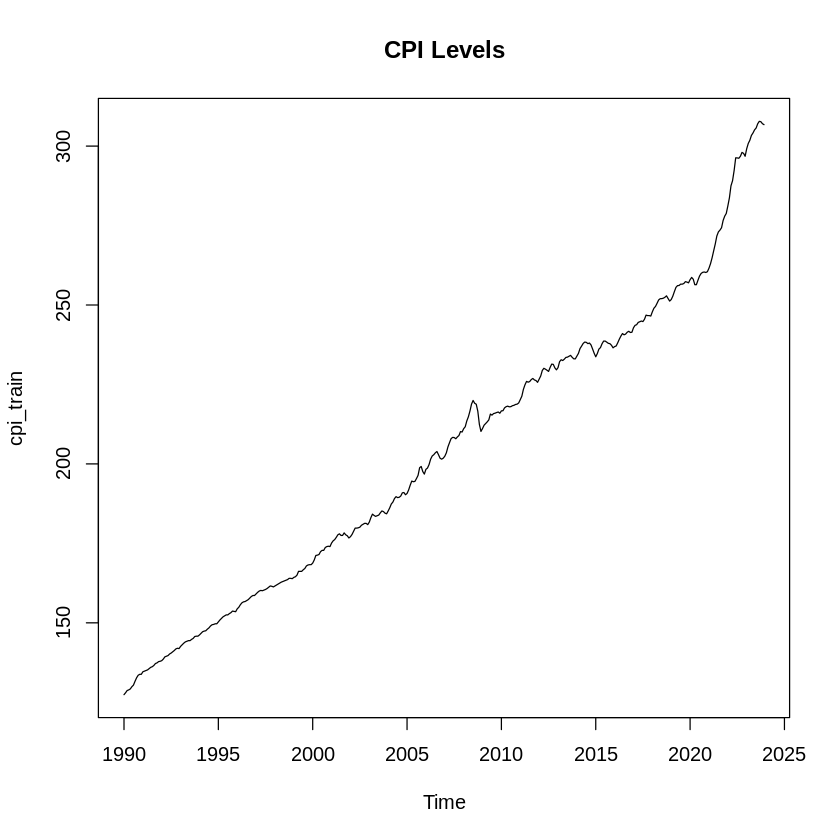

Series: cpi_train 
ARIMA(0,2,3)(0,0,2)[12] 

Coefficients:
          ma1      ma2      ma3    sma1    sma2
      -0.3859  -0.4551  -0.1355  0.1805  0.1338
s.e.   0.0498   0.0500   0.0532  0.0534  0.0483

sigma^2 = 0.3929:  log likelihood = -385.49
AIC=782.99   AICc=783.2   BIC=807.03

Training set error measures:
                     ME      RMSE       MAE         MPE      MAPE       MASE
Training set 0.01717916 0.6214364 0.4375386 0.003690955 0.2069341 0.08136579
                     ACF1
Training set -0.001590032

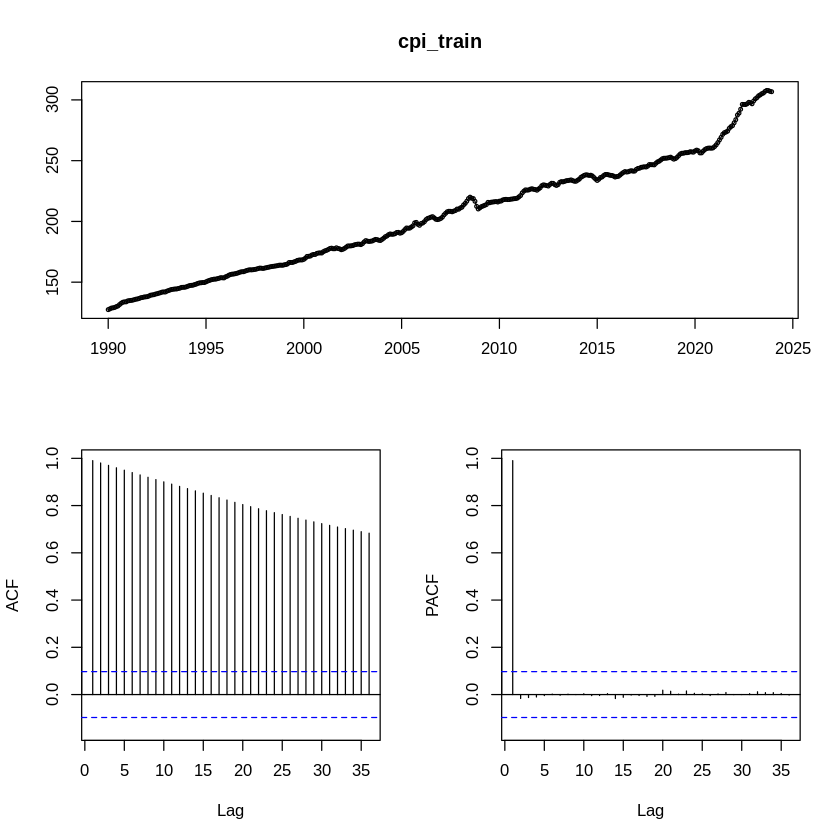


	Ljung-Box test

data:  Residuals from ARIMA(0,2,3)(0,0,2)[12]
Q* = 39.993, df = 19, p-value = 0.003279

Model df: 5.   Total lags used: 24



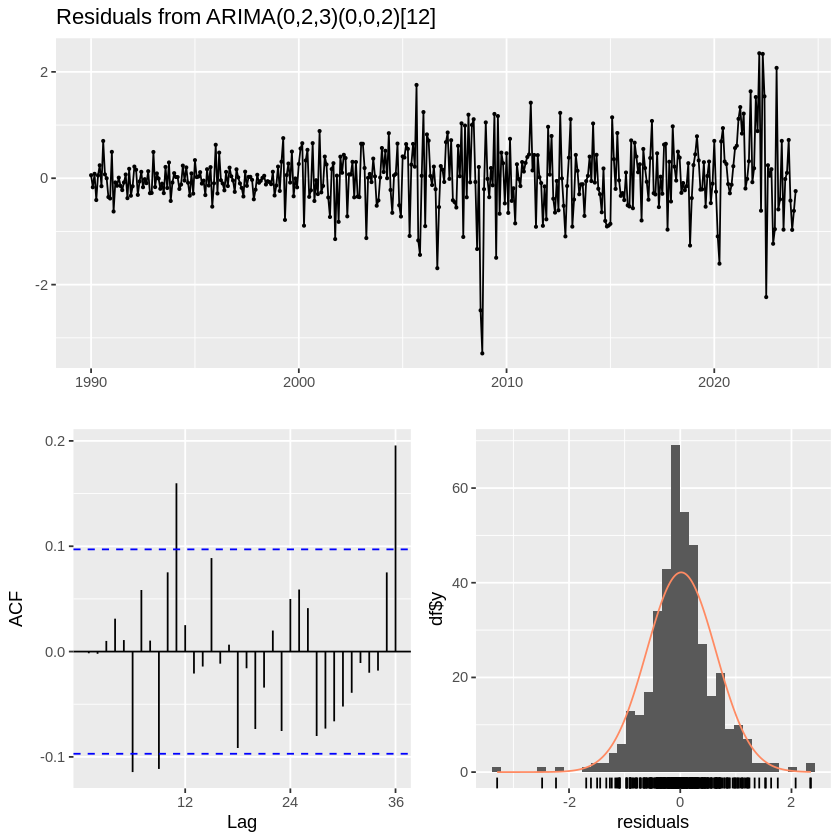

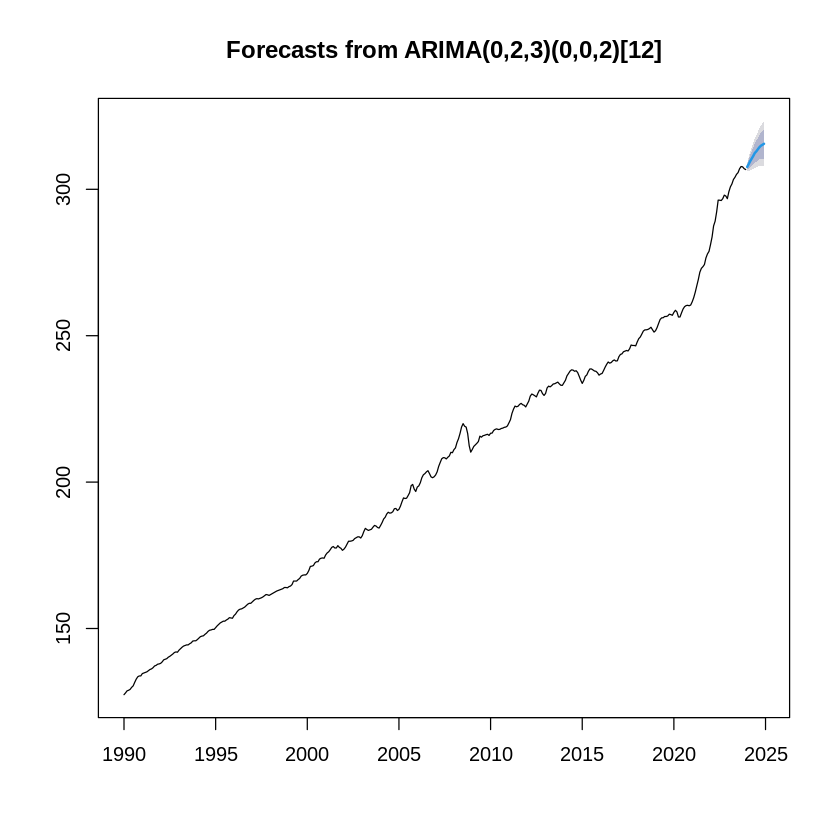

Warning message in adf.test(inflation_train):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  inflation_train
Dickey-Fuller = -4.1531, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


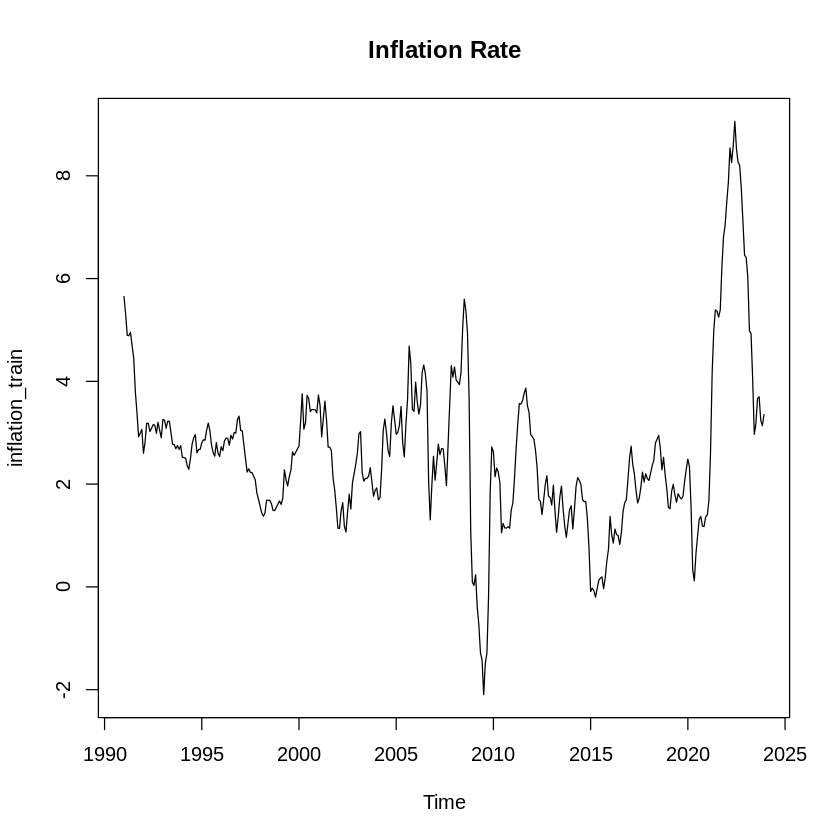

Series: inflation_train 
ARIMA(2,0,2)(2,0,0)[12] with non-zero mean 

Coefficients:
         ar1     ar2     ma1     ma2     sar1     sar2    mean
      0.7097  0.2720  0.8115  0.2276  -0.7195  -0.3875  3.0838
s.e.  0.4023  0.3977  0.3965  0.1972   0.0477   0.0479  0.7155

sigma^2 = 0.08338:  log likelihood = -72.06
AIC=160.12   AICc=160.49   BIC=191.97

Training set error measures:
                      ME      RMSE       MAE       MPE     MAPE      MASE
Training set -0.00676869 0.2861928 0.2098545 -2.138619 21.31275 0.1535148
                     ACF1
Training set -0.003609172

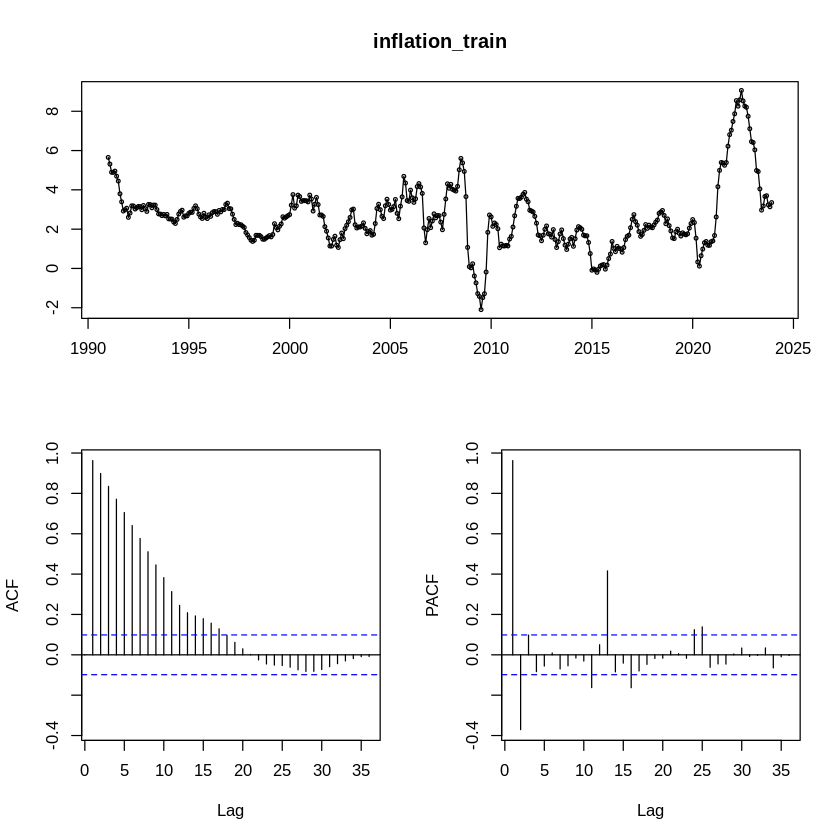


	Ljung-Box test

data:  Residuals from ARIMA(2,0,2)(2,0,0)[12] with non-zero mean
Q* = 46.345, df = 18, p-value = 0.0002642

Model df: 6.   Total lags used: 24



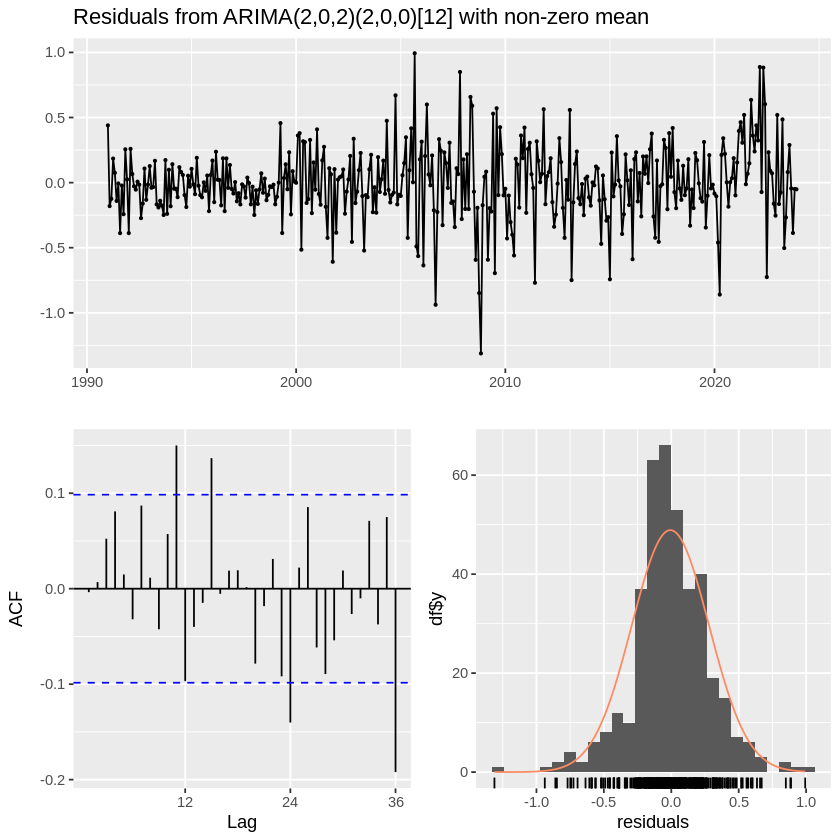

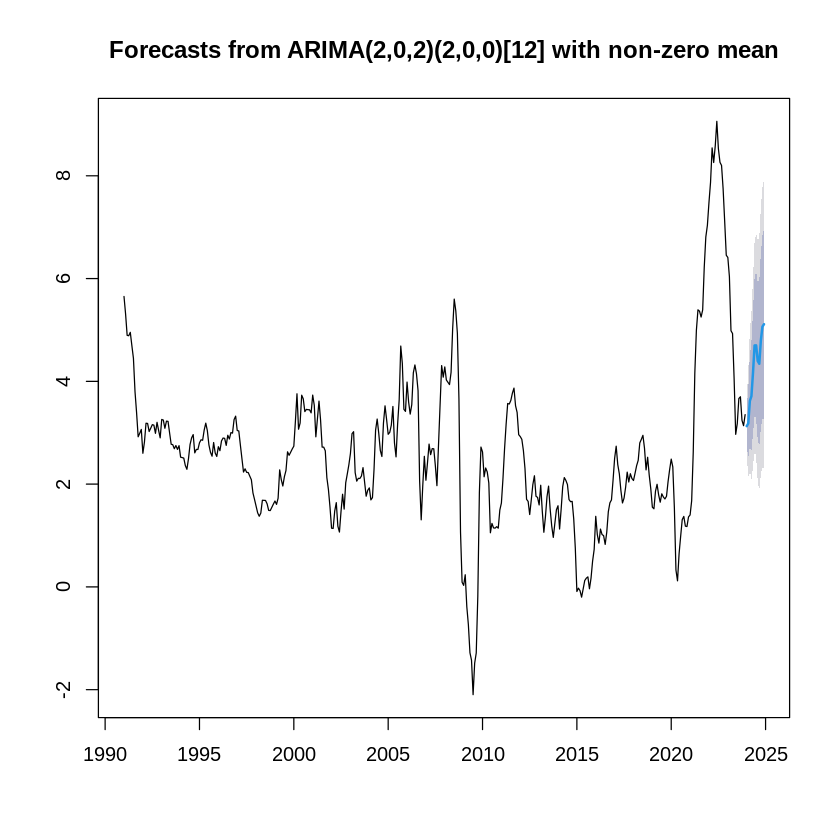

In [ ]:
#ARIMA on CPI levels
plot(cpi_train, main = "CPI Levels")
adf.test(cpi_train)
tsdisplay(cpi_train)

cpi_arima <- auto.arima(cpi_train, seasonal = TRUE)
summary(cpi_arima)
checkresiduals(cpi_arima)

cpi_forecast <- forecast(cpi_arima, h = 12)
plot(cpi_forecast)
cpi_accuracy <- accuracy(cpi_forecast, cpi_test)

#ARIMA on inflation rate
plot(inflation_train, main = "Inflation Rate")
adf.test(inflation_train)
tsdisplay(inflation_train)

inflation_arima <- auto.arima(inflation_train, seasonal = TRUE)
summary(inflation_arima)
checkresiduals(inflation_arima)

inflation_forecast <- forecast(inflation_arima, h = 12)
plot(inflation_forecast)
inflation_accuracy <- accuracy(inflation_forecast, inflation_test)

compare

In [ ]:
#compare results
cat("CPI ARIMA Test RMSE:", cpi_accuracy[2, "RMSE"], "\n")
cat("Inflation ARIMA Test RMSE:", inflation_accuracy[2, "RMSE"], "\n")

CPI ARIMA Test RMSE: 1.707334 
Inflation ARIMA Test RMSE: 1.565726 


select best approach

In [ ]:
if(cpi_accuracy[2, "RMSE"] < inflation_accuracy[2, "RMSE"]) {
  cat("Winner: CPI Levels ARIMA")
} else {
  cat("Winner: Inflation Rate ARIMA")
}

Winner: Inflation Rate ARIMA